# Submission 1: Price a Vanilla European Call Option

Joe Hoong Ng (ng_joehoong@hotmail.com)

Dang Duy Nghia Nguyen (nghia002@e.ntu.edu.sg)

Dylan Thorne (dylan.thorne@gmail.com)

Zain Us Sami Ahmed Ansari (zainussami@gmail.com)	

In this submission we price a vanilla European call option and we allow the volatility term to vary.

#### Part 1 : Using a simple Fourier pricing technique, price a vanilla call option assuming that the underlying share follows the Heston model dynamics.

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

Black-Scholes option pricing models assumed volatility of the underlying assets to be constant or a predetermined function of time, we will now implement a model which features instantaneous variance of asset price using volatility that evolves stochastically in time.  Although there are several models incorporating stochastic volatility including introduced by Hull and White [1], Stein and Stein [2] and  Heston [3] [4],  we will implement Heston’s constant interest rate model.

In [2]:
#Share Specific Information
r = 0.08 #risk-free continuously compounded interest rate 
S0 = 100 #current share price 
v0 = 0.06
kappa = 9
theta = 0.06
sigma = 0.3
rho = -0.4

#Call Specific Information
K = 100
T = 1
k_log = np.log(K)

#Approximation Information

t_max = 30
N = 100

The Characteristic function is implemented using a function presented by Albrecher et al [5].  The function is written as:
$$\phi_{S_T} = exp(C(\tau;u)+D(\tau;u)v_t + iu \log(S_t) )$$

Where,

$$C(\tau;u) = ri\tau u + \theta \kappa [\tau x\_ - \frac{1}{a}\log(\frac{1-ge^{d\tau}}{1-g})],$$

$$D(\tau;u) = (\frac{1-e^{d\tau}}{1-ge^{d\tau}})x\_,$$

$$\tau = T -t ,$$

$$ g = \frac{x\_}{x_+},$$

$$ x_\pm = \frac{b\pm d}{2a},$$

$$ d = \sqrt{b^2 - 4ac},$$

$$ c = - \frac{u^2 + Ui}{2},$$

$$ b = \kappa - \rho \sigma iu,$$

$$ a = \frac {\sigma^2}{2}$$

In [3]:
#Characteristic function code

a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

Now we vectorize the code, calculate an estimate for integrals and calculate the Fourier estimate of our call price.

In [4]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

#Integral calculations
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

#Call value
fourier_call_val = S0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
fourier_call_val

13.734895692109049

To see the effectiveness of the pricing option under Heston dynamics we will also price the call option under Black-Scholes assumption.

In [5]:
# Code for analytical solution for vanilla European Call option
d_1_stock = (np.log(S0/K)+(r + sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S0*norm.cdf(d_1_stock)-K*np.exp(-r*(T))*norm.cdf(d_2_stock)
analytic_callprice

15.711312547892973

# Part 2

Assume that $\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$, where $\sigma = 0.3$ and $\gamma = 0.75$. Using the formula below, simulate paths for the underlying share using sample sizes of 1000, 2000, …, 50000. Perform monthly simulations for a period of a year. We can simulate the next step in a share price path using the following formula:
$$S_{t_{i+1}} = S_{t_i}e^{(r - \frac{\sigma^2 (t_i,t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$$
where $S_{ti}$ is the share price at time $t_i$, $\sigma(t_i, t_{i+1})$ is the volatility for the period $[t_i,t_{i+1}]$, r is the risk-free interest rate, and Z~N(0, 1)

Note that we are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period.

In [6]:
#from question
sigma_const = 0.30
gamma = 0.75

#assumption
r = 0.08
S0 = 100
T = 1
sample_sizes = range(1000, 50001, 1000)

timesteps = 12

First, we define our helper functions. The next_share_price function is used to calculate the evolution of the share price at t+1, from the share price at t. We generate the random variable Z from within this function. The effective sigma is also written as a function of the share price at t. 

Just for exploration purposes, we also added a varying_vol flag, to allow us to switch between a constant volatility and varying volatility. We use the initial stock price instead of the previous price when assuming a contant volatility.

The other function is the generate_share_price_path function. We first create an empty numpy array of shape (sample_size x timesteps+1). Note the addition of one element to the timestep, as the first element is equal to the initial stock price. We then iterate through each path, and each timestep, applying the next_share_price function against the previous share price. We then convert the result into a pandas DataFrame and return the results.

In [7]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, varying_vol = True):
    Z = stats.norm.rvs(size=sample_size)
    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
        
    return prev_price*np.exp((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z)

def generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol = True):
    df = pd.DataFrame([S0]*sample_size)
    for t in range(1, timesteps+1):
        df[t] = next_share_price(df[t-1], r, 1/timesteps, sigma_const, gamma, sample_size, varying_vol)
    return df.T

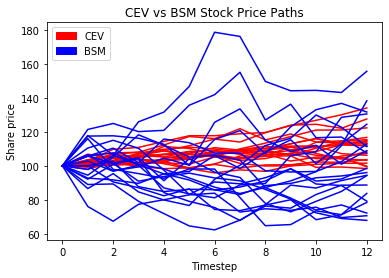

In [8]:
import matplotlib.patches as mpatches
T = 10
sample_size = 20

share_price_path_cev = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps)
share_price_path_black_scholes = generate_share_price_path(S0, r, T, sigma_const, 1.0, sample_size, timesteps, varying_vol=False)

plt.plot(share_price_path_cev, color='red')
plt.plot(share_price_path_black_scholes, color='blue')
plt.xlabel("Timestep")
plt.ylabel("Share price")
red_patch = mpatches.Patch(color='red', label='CEV')
blue_patch = mpatches.Patch(color='blue', label='BSM')
plt.legend(handles=[red_patch, blue_patch], loc='upper left')
plt.title("CEV vs BSM Stock Price Paths")
plt.show()

Next, we create a python dictionary called share_price_paths, to hold our results for part 2. The key of this dictionary would be the number of sample price paths, while the values would be the dataframes containing the price paths. We also track the rough processing time required at each step, by printing the time when each iteration completes.

In [9]:
import time

T = 1
sample_sizes = range(1000, 50001, 1000)

share_price_paths = {}

print("Start generating share price path")
start = time.time()
for sample_size in sample_sizes:
    share_val = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol=False) 
     
    share_price_paths[sample_size] = share_val
    #print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))
end = time.time()
print(f"Generating all samples paths takes {(end - start):.2f}s")

Start generating share price path
Generating all samples paths takes 2.58s


To display our output, we show the first 10 price paths generated by our iteration with 1000 samples:

In [10]:
share_price_paths[1000].iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.626771,99.374526,100.689569,97.065445,106.862386,99.918343,106.483031,100.796117,100.030802,102.593647
2,103.745565,96.967926,102.622183,96.451414,106.332275,96.640428,105.512423,101.627748,98.448810,103.179244
3,107.154631,96.585243,105.974778,93.207852,100.177288,99.129417,107.821291,98.518154,97.598741,103.563761
4,111.716818,95.838855,101.540594,94.146336,98.646601,102.592136,108.394844,97.918995,99.489053,110.865271
5,120.620494,93.477848,100.930914,94.502805,100.662067,103.175996,108.425203,99.326116,97.269739,108.916593
6,122.217586,87.674152,101.799340,91.076602,101.876289,102.336328,107.844372,103.199284,98.432527,108.089622
7,123.138256,87.108925,103.904210,94.061221,106.060742,103.426255,108.269775,100.286497,101.084604,107.860547
8,129.359695,87.871374,100.925245,92.948402,115.010833,98.206543,108.268731,99.113198,101.552266,103.792957
9,123.575048,87.571414,105.883449,95.799071,117.769685,97.640631,103.400905,98.076554,100.633537,106.623775


Next, we plot the price paths for the iteration with 1000 samples, 

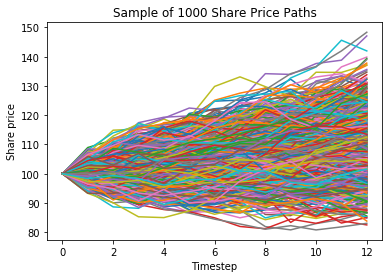

In [11]:
plt.plot(share_price_paths[1000])
plt.xlabel('Timestep')
plt.ylabel('Share price')
plt.title('Sample of 1000 Share Price Paths')
plt.show()

# Part 3

Using Monte Carlo, we calculate the price of the vanilla call option as follows:

In [12]:
price_estimate = []
price_std = []


for size in sample_sizes:
    S_Ts = share_price_paths[size].iloc[12, :]
    payoff = np.maximum(S_Ts - K, 0)
    discounted_price = np.exp(-r*T)*payoff
    price_estimate.append(discounted_price.mean())
    price_std.append(discounted_price.std()/np.sqrt(size))

In [13]:
print("The price estimated by Monte Carlo when using sample size of 50,000 is : {:.3f}".format(price_estimate[-1])) 

The price estimated by Monte Carlo when using sample size of 50,000 is : 8.694


### Comparison with calculation of CEV model using noncentral chi-squared distribution 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2

S0 = 100
sigma = 0.3
gamma = 0.75
r = 0.08
T = 1

In [15]:
z = 2 + 1/(1-gamma)
def C(t,K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

In [16]:
cev_call_price = C(T, 100)

In [17]:
print("The price calculated via CEV model using noncentral chi-squared distribution is : {:.3f}".format(cev_call_price))

The price calculated via CEV model using noncentral chi-squared distribution is : 8.702


# Part 4

We plot the prices of our Monte Carlo estimates against the CEV noncentral chi-squared distribution prices calculated from Part 1 above:

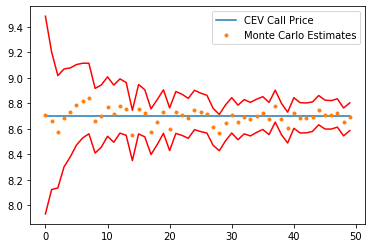

In [18]:
plt.plot([cev_call_price]*50, label='CEV Call Price')
plt.plot(price_estimate, '.', label='Monte Carlo Estimates')
plt.plot(price_estimate + 3*np.array(price_std), 'r')
plt.plot(price_estimate - 3*np.array(price_std), 'r')
plt.legend()
plt.show()

We also plot the prices of our Monte Carlo estimates against the Fourier Call prices calculated from Part 1 above:

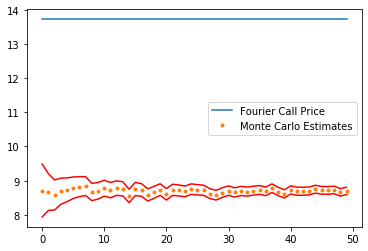

In [19]:
plt.plot([fourier_call_val]*50, label='Fourier Call Price')
plt.plot(price_estimate, '.', label='Monte Carlo Estimates')
plt.plot(price_estimate + 3*np.array(price_std), 'r')
plt.plot(price_estimate - 3*np.array(price_std), 'r')
plt.legend()
plt.show()

We notice that there is a discrepency. Upon further investigation, for the Heston model, v_0 = 0.06 (v_0 = stock volatility ^ 0.5), so stock volatility = .06**0.5= 0.2449. Note that sigma under Heston model refers to volatility of stock volatility

Under our stock price Monte Carlo calculation, the default stock volatility is 0.0948 (given by  0.3*(100)*-.25 ). Thus its much less than Heston. To have the same initial stock volatility, we find a new value for $\sigma$ by equating $\sigma(S_{ti})^{\gamma-1} = \sqrt{0.06}$, giving us $\sigma = 0.775$. 

We then find that our newly calculated Monte Carlo calculated call prices are aligned with the Fourier prices.

In [20]:
sigma_const = 0.775

T = 1
sample_sizes = range(1000, 50001, 1000)

share_price_paths = {}

print("Start generating share price path")
start = time.time()
for sample_size in sample_sizes:
    share_val = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol=False) 
     
    share_price_paths[sample_size] = share_val
    #print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))
end = time.time()
print(f"Generating all samples paths takes {(end - start):.2f}s")

Start generating share price path
Generating all samples paths takes 2.10s


In [21]:
price_estimate = []
price_std = []


for size in sample_sizes:
    S_Ts = share_price_paths[size].iloc[12, :]
    payoff = np.maximum(S_Ts - K, 0)
    discounted_price = np.exp(-r*T)*payoff
    price_estimate.append(discounted_price.mean())
    price_std.append(discounted_price.std()/np.sqrt(size))

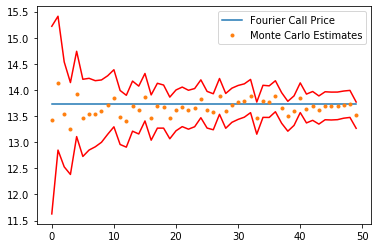

In [22]:
plt.plot([fourier_call_val]*50, label='Fourier Call Price')
plt.plot(price_estimate, '.', label='Monte Carlo Estimates')
plt.plot(price_estimate + 3*np.array(price_std), 'r')
plt.plot(price_estimate - 3*np.array(price_std), 'r')
plt.legend()
plt.show()

### References

[1] Hull, J. and White, A. (1987). The pricing of options on assets with stochastic volatilities. The journal of finance, 42(2):281–300.

[2] Stein, E. M. and Stein, J. C. (1991). Stock price distributions with stochastic volatility: an analytic approach. Review of financial Studies, 4(4):727–752.

[3] Heston, S. L. (1993). A closed-form solution for options with stochastic volatility with applications to bond and currency options. Review of financial studies, 6(2):327–343. 

[4] Heston, S. L. (1997). A simple new formula for options with stochastic volatility. 

[5] Albrecher, H., Mayer, P., Schoutens, W. and Tistaert, J. (2007). “The Little Heston Trap”, Wilmott (1): 83–92.


